# Chapter 15: Other Types of Signals

For additional context see Chapter 15 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [18]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr
import matplotlib.ticker as mticker

import warnings

%matplotlib inline

## Get the data

This chapter uses three datasets.

The first dataset is the death-to-birth rates at the year level. This file is called `vienna-general-death-to-birth-rates-by-clinic.csv`. 

The second dataset is the death-to-birth rates at the month level. This file is called `impact-of-handwashing-death-to-birth-rates.csv`.

The third dataset is the home runs hit by Barry Bonds. This dataset called `home-runs-by-season.csv`.

The dataset can be found at https://github.com/jimlehner/the-virus-of-variation/tree/main/data.

In [2]:
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

## Death-to-birth rates at year level

In [3]:
# Rate URL
rate_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/vienna-general-death-to-birth-rates-by-clinic.csv'

# Get data
rate_df = get_data(rate_url)

# # Drop unnecessary columns
rate_df = rate_df.drop(['Hospital', 
                        'Employee', 
                        'Note'], axis=1)

# Specify 'Year' column dtype as string
rate_df['Year'] = rate_df['Year'].astype('string')

# Calculate the moving range
rate_df['Moving Range'] = abs(rate_df['Rate'].diff())

# Show dataframe
rate_df.head()

,Clinic,Year,Births,Deaths,Rate,Moving Range
0,1st Clinic,1833,3737,197,5.3,NaN
1,1st Clinic,1834,2657,205,7.7,2.4
2,1st Clinic,1835,2573,143,5.6,2.1
3,1st Clinic,1836,2677,200,7.5,1.9
4,1st Clinic,1837,2765,251,9.1,1.6


In [4]:
# Get clinic groups
grouped_df = rate_df.groupby('Clinic')

# Create first and second clinic dataframes
first_clinic = grouped_df.get_group('1st Clinic')
second_clinic = grouped_df.get_group('2nd Clinic').reset_index(drop=True)

## Death-to-birth rates at month level

In [5]:
# Month URL
month_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/impact-of-handwashing-death-to-birth-rates.csv'

# Get data
month_df = get_data(month_url)

# Drop unnecessary columns
month_df = month_df.drop(['Hospital', 
                          'Month', 
                          'Year', 
                          'Year', 
                          'Births', 
                          'Deaths'], axis=1)

# Specify 'Year' column dtype as string
month_df['MonthYear'] = month_df['MonthYear'].astype('string')

# Calculate the moving range
month_df['Moving Range'] = abs(month_df['Rate'].diff())

# Show dataframe
month_df.head()

month_df['Stage'].unique()

array(['Before handwashing', 'After handwashing'], dtype=object)

In [16]:
# Create after dataframe
after_df = month_df[month_df['Stage'] == 'After handwashing'].reset_index(drop=True).drop(columns='Moving Range')
# Recaclulate 'Moving Ranges'
after_df['Moving Range'] = abs(after_df['Rate'].diff())
after_df.head()

,Stage,MonthYear,Rate,Moving Range
0,After handwashing,Jun-47,2.2,NaN
1,After handwashing,Jul-47,1.2,1.0
2,After handwashing,Aug-47,1.9,0.7
3,After handwashing,Sep-47,4.6,2.7
4,After handwashing,Oct-47,4.0,0.6


## Get home run data

In [7]:
# Sales dataset url
home_run_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/home-runs-by-season.csv'

# Get data
home_run_df = get_data(home_run_url)

# Make 'Year' column dtype string
home_run_df['Year'] = home_run_df['Year'].astype('string')

# Drop 'Sample', 'Team', and Notes'column
home_run_df = home_run_df.drop(['Sample','Team','Notes'], axis=1)

# Show dataframe
home_run_df.head()

,Player,Year,HR
0,B. Bonds,1986,16
1,B. Bonds,1987,25
2,B. Bonds,1988,24
3,B. Bonds,1989,19
4,B. Bonds,1990,33


In [8]:
# Get on Bonds data
bonds_df = home_run_df[home_run_df['Player'].str.contains('Bonds')].copy()
bonds_df['Moving Range'] = abs(bonds_df['HR'].diff())
len(bonds_df)

22

## Figure 15.1: Rule 1 satisfied with a value outside the limits

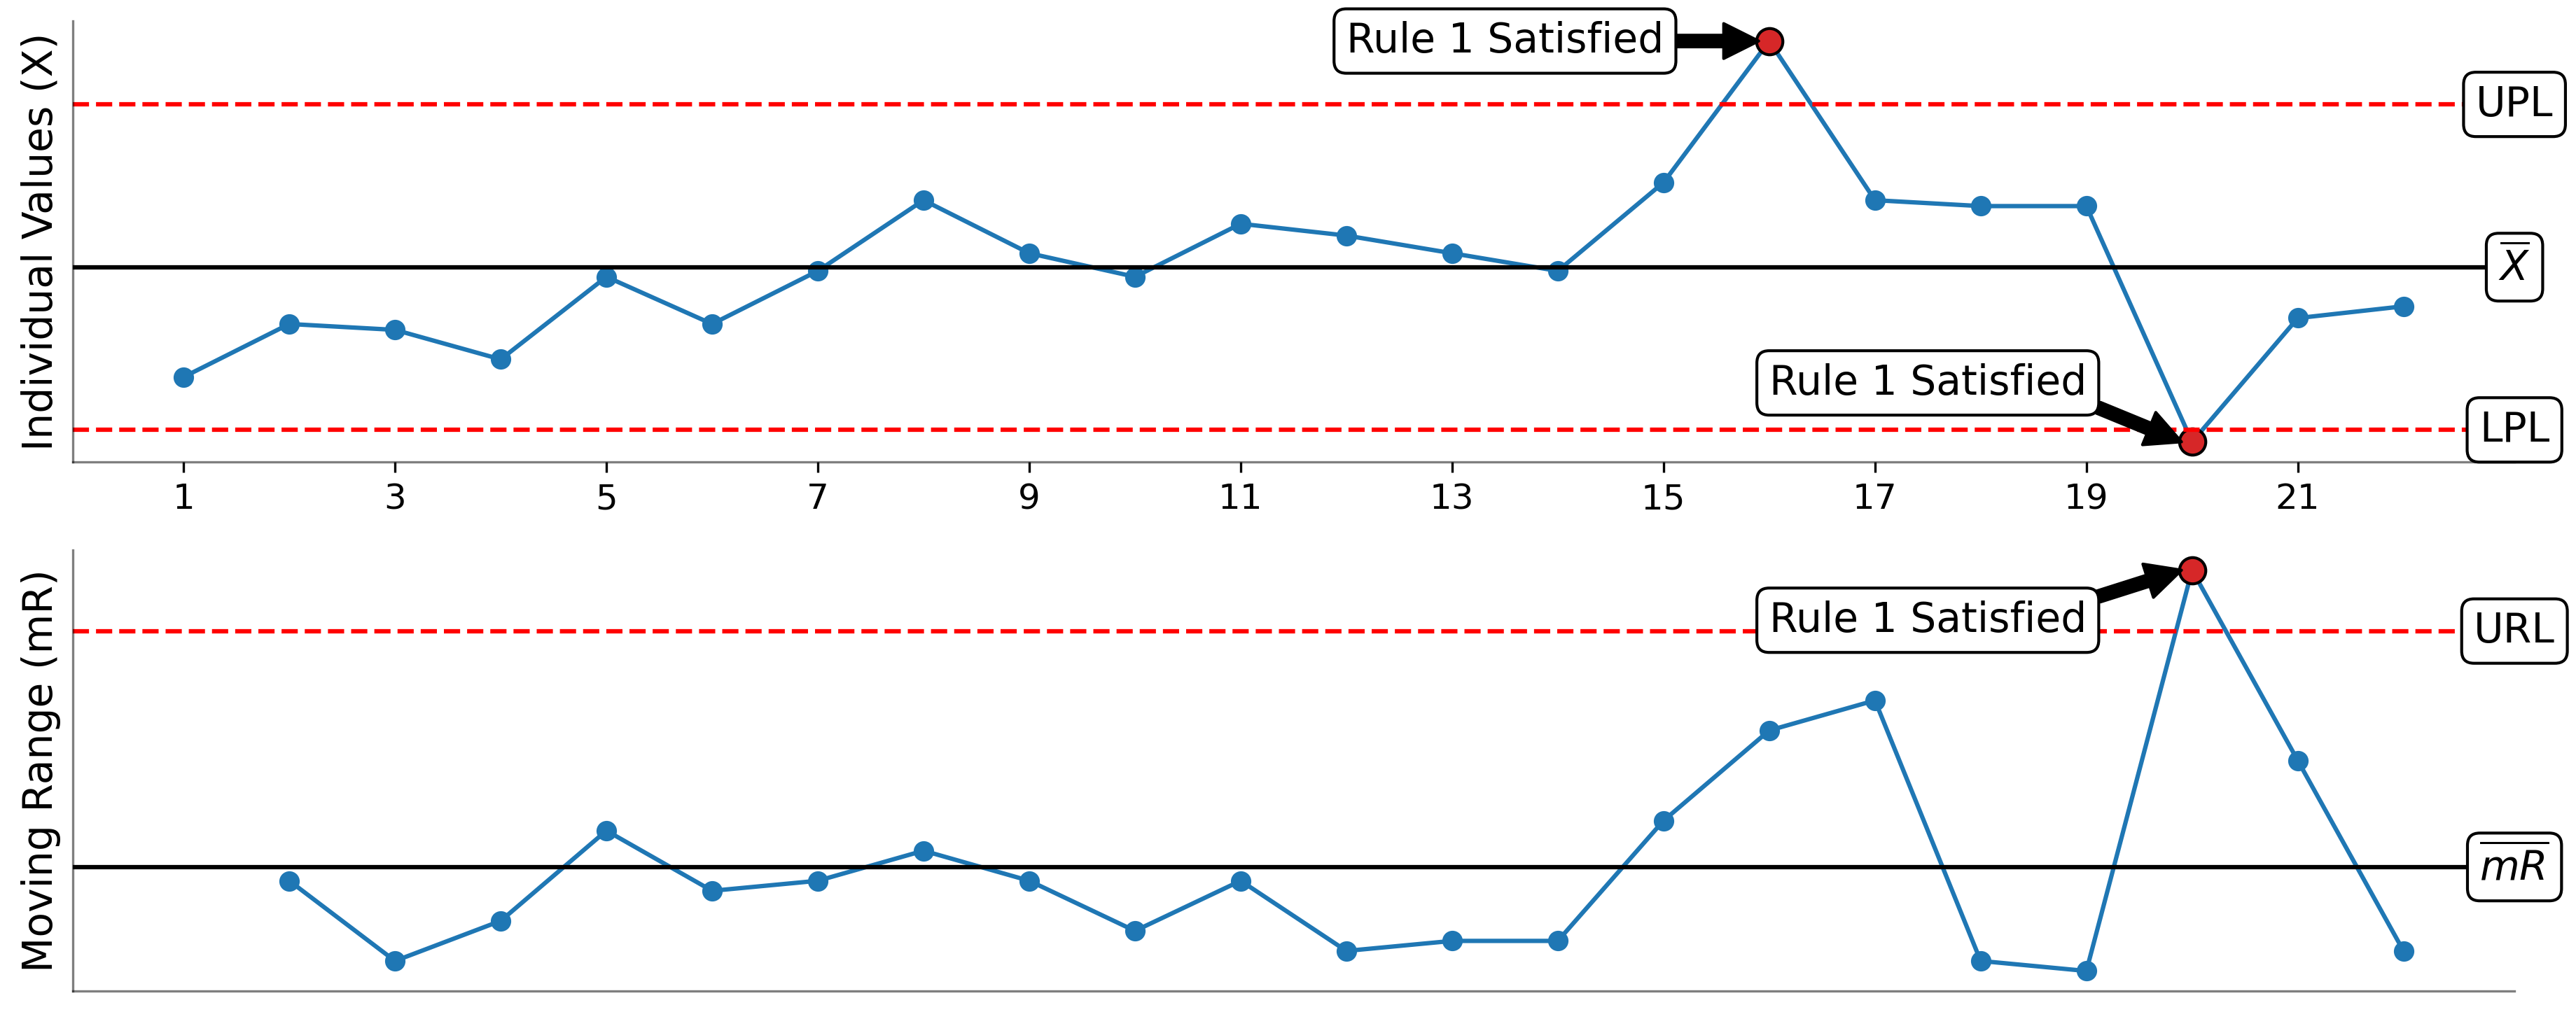

In [9]:
# Specify tickinterval
tickinterval = 2

# Specify round_value
round_value = 2

# Disaggregate the dataframe 
data = bonds_df["HR"]
moving_ranges = round(abs(data.diff()),round_value)
# labels = bonds_df["Year"]
labels = pd.Series(np.arange(1,23)).astype('string')

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = max(0,round(mean - (C1*average_mR),round_value))
# Calculate process limit range (PLR)
PLR = UPL - LPL

# Calculate the Upper Range Limit
URL = round(C2*average_mR, round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR,'-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Add moving ranges to df as column
first_clinic = first_clinic.copy()
first_clinic['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = round(mean - (C1*average_mR),round_value)
# Calculate process limit range (PLR)
PLR = UPL - LPL
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)
# Calculate the Upper Range Limit
URL = round(C2*average_mR,round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR,'-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Generate the X-chart
fig, ax = plt.subplots(2, 1, figsize=(15,6), dpi=300)

# Plot data
ax[0].plot(labels, data, marker='o')
ax[1].plot(labels, moving_ranges, marker='o')
    
# Offset moving ranges from individual values by 1.
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add masking parameters to color values outside process limits
ax[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax[0].text(ax[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)

# text labels for limits and central line on mR chart
ax[1].text(ax[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[1].text(ax[1].get_xlim()[1], average_mR, r'$\overline{mR}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, c=color)
# Add central line and process limits to mR chart
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, color=color)

# Specify spine visibility 
sns.despine()
ax[0].spines[['left','bottom']].set_alpha(0.5)
ax[1].spines[['left','bottom']].set_alpha(0.5)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)
# Remove xticks from mR chart
ax[1].set_xticks([])

# Specify axis labels and title
ax[0].set_xlabel("",fontsize=12)
ax[0].set_ylabel("Individual Values (X)", fontsize=14)
ax[0].set_title("", fontsize=14)
ax[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Add annotation for highlighting value that satisfies Rule 1
ax[0].annotate('Rule 1 Satisfied', 
             xy=(14.9, 73),  # x, y coordinates of the annotation
             xytext=(12.5, 73),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), 
             arrowprops=dict(facecolor='black'))

# Add annotation for highlighting value that satisfies Rule 1
ax[0].annotate('Rule 1 Satisfied', 
             xy=(18.9, 5),  # x, y coordinates of the annotation
             xytext=(16.5, 15),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), 
             arrowprops=dict(facecolor='black'))

# Add annotation for highlighting value that satisfies Rule 1
ax[1].annotate('Rule 1 Satisfied', 
             xy=(18.9, 40),  # x, y coordinates of the annotation
             xytext=(16.5, 35),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), 
             arrowprops=dict(facecolor='black'))

# Remove yticks
for axes in range(0,2):
    ax[axes].set_yticks([])

# Show plot
plt.show()

## Figure 15.1: Rule 1 satisfied with a value outside the limits

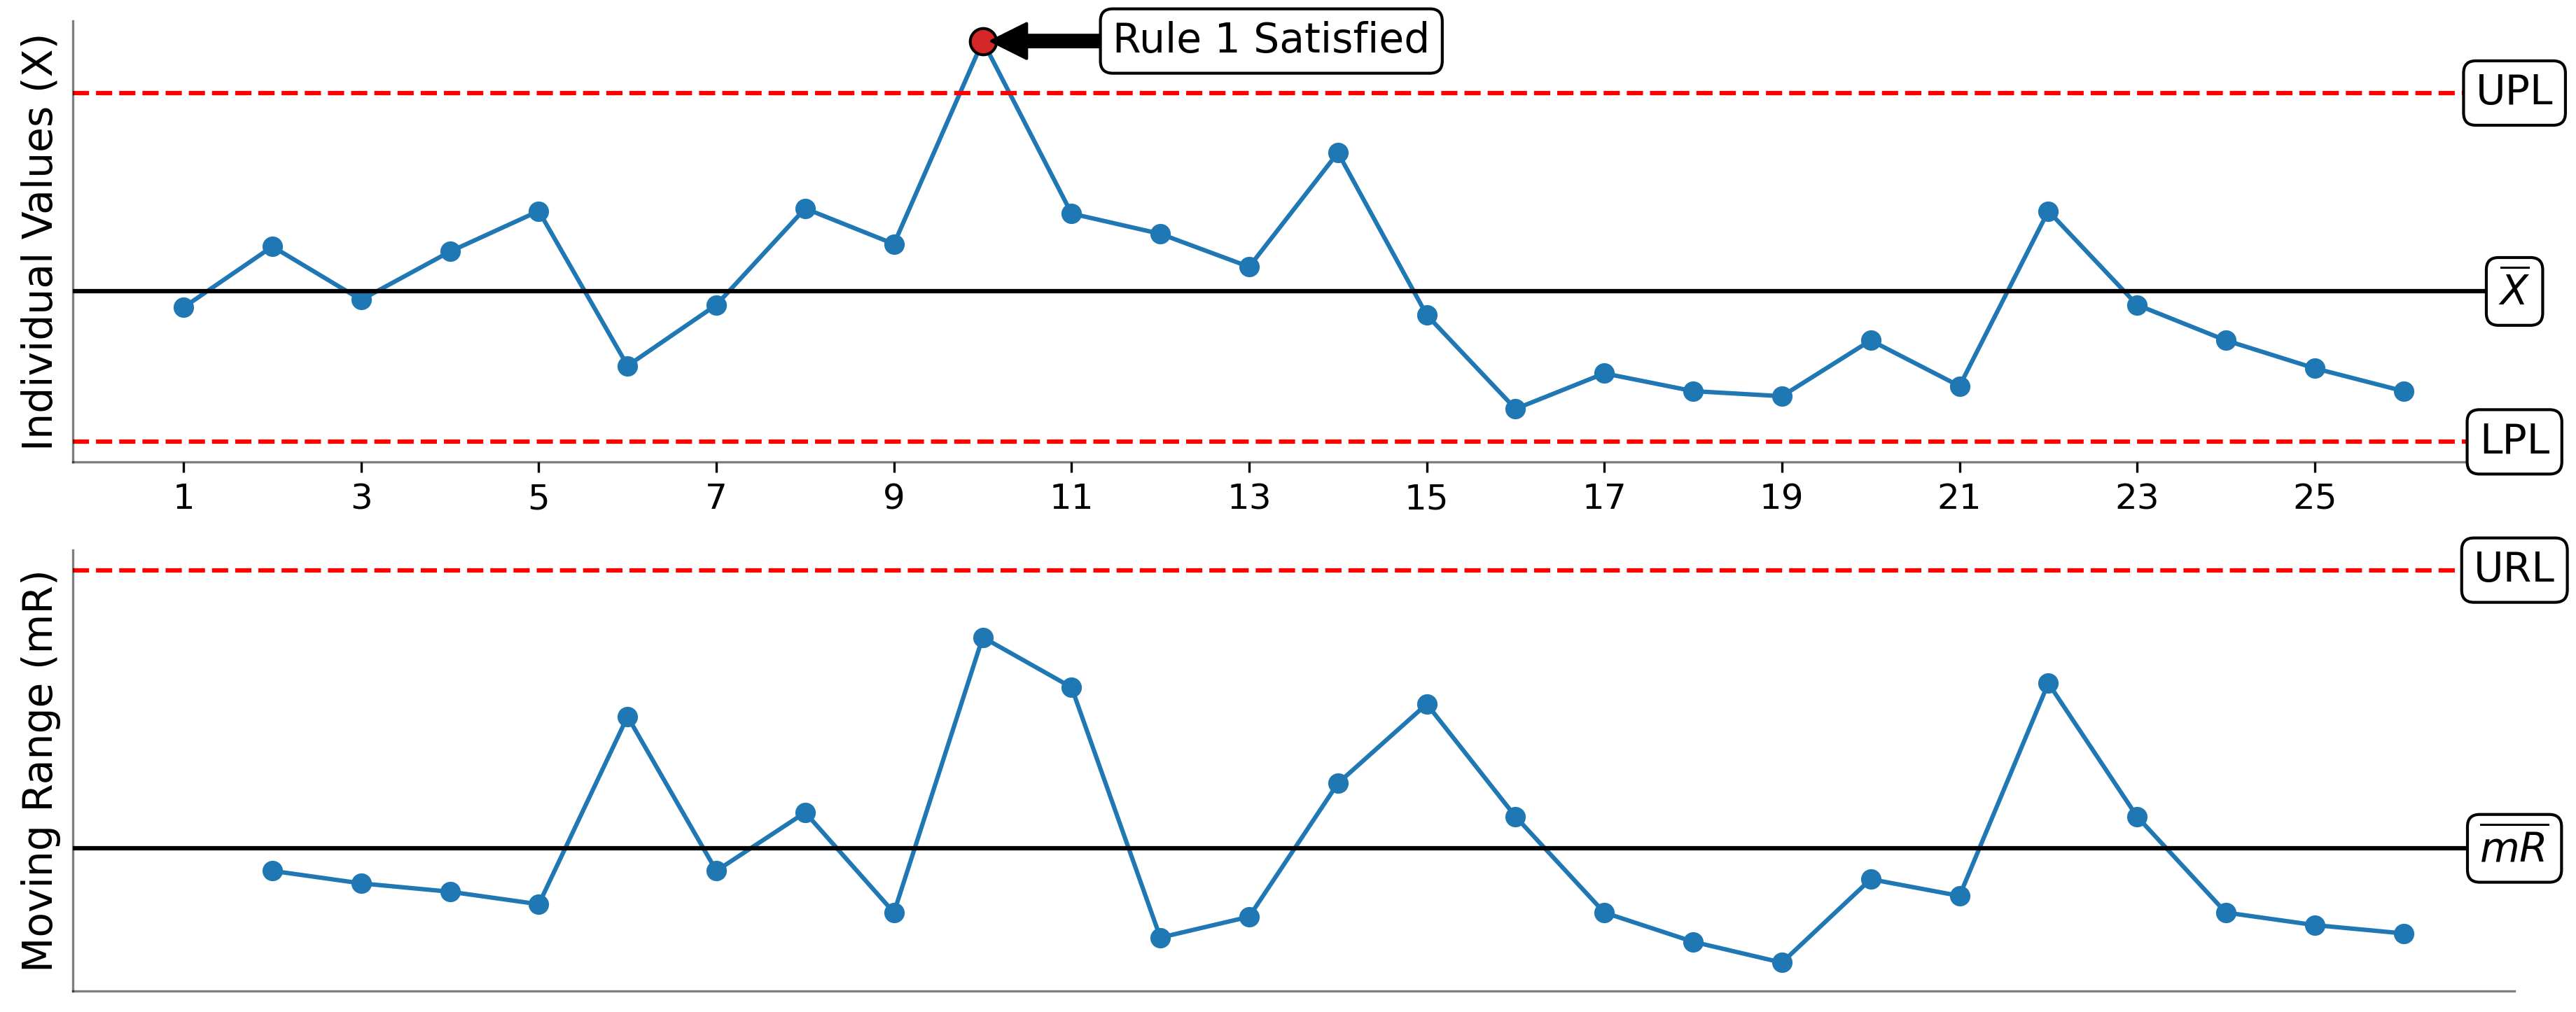

In [10]:
# Specify tickinterval
tickinterval = 2

# Specify round_value
round_value = 2

# Disaggregate the dataframe 
data = first_clinic["Rate"]
moving_ranges = round(abs(data.diff()),round_value)
# labels = first_clinic["Year"]
labels = pd.Series(np.arange(1,27)).astype('string')

# Add moving ranges to df as column
first_clinic = first_clinic.copy()
first_clinic['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = max(0,round(mean - (C1*average_mR),round_value))
# Calculate process limit range (PLR)
PLR = UPL - LPL

# Calculate the Upper Range Limit
URL = round(C2*average_mR, round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR,'-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Add moving ranges to df as column
first_clinic = first_clinic.copy()
first_clinic['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = round(mean - (C1*average_mR),round_value)
# Calculate process limit range (PLR)
PLR = UPL - LPL
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)
# Calculate the Upper Range Limit
URL = round(C2*average_mR,round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR,'-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Generate the X-chart
fig, ax = plt.subplots(2, 1, figsize=(15,6), dpi=300)

# Plot data
ax[0].plot(labels, data, marker='o')
ax[1].plot(labels, moving_ranges, marker='o')
    
# Offset moving ranges from individual values by 1.
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add masking parameters to color values outside process limits
ax[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax[0].text(ax[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)

# text labels for limits and central line on mR chart
ax[1].text(ax[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[1].text(ax[1].get_xlim()[1], average_mR, r'$\overline{mR}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, c=color)
# Add central line and process limits to mR chart
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, color=color)

# Specify spine visibility 
sns.despine()
ax[0].spines[['left','bottom']].set_alpha(0.5)
ax[1].spines[['left','bottom']].set_alpha(0.5)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)
# Remove xticks from mR chart
ax[1].set_xticks([])

# Specify axis labels and title
ax[0].set_xlabel("",fontsize=12)
ax[0].set_ylabel("Individual Values (X)", fontsize=14)
ax[0].set_title("", fontsize=14)
ax[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Add annotation for highlighting value that satisfies Rule 1
ax[0].annotate('Rule 1 Satisfied', 
             xy=(9.1, 15.8),  # x, y coordinates of the annotation
             xytext=(12.25, 15.8),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), 
             arrowprops=dict(facecolor='black'))

# Remove yticks
for axes in range(0,2):
    ax[axes].set_yticks([])

# Show plot
plt.show()

## Figure 15.2: Rule 2 satisfied with a run of 8

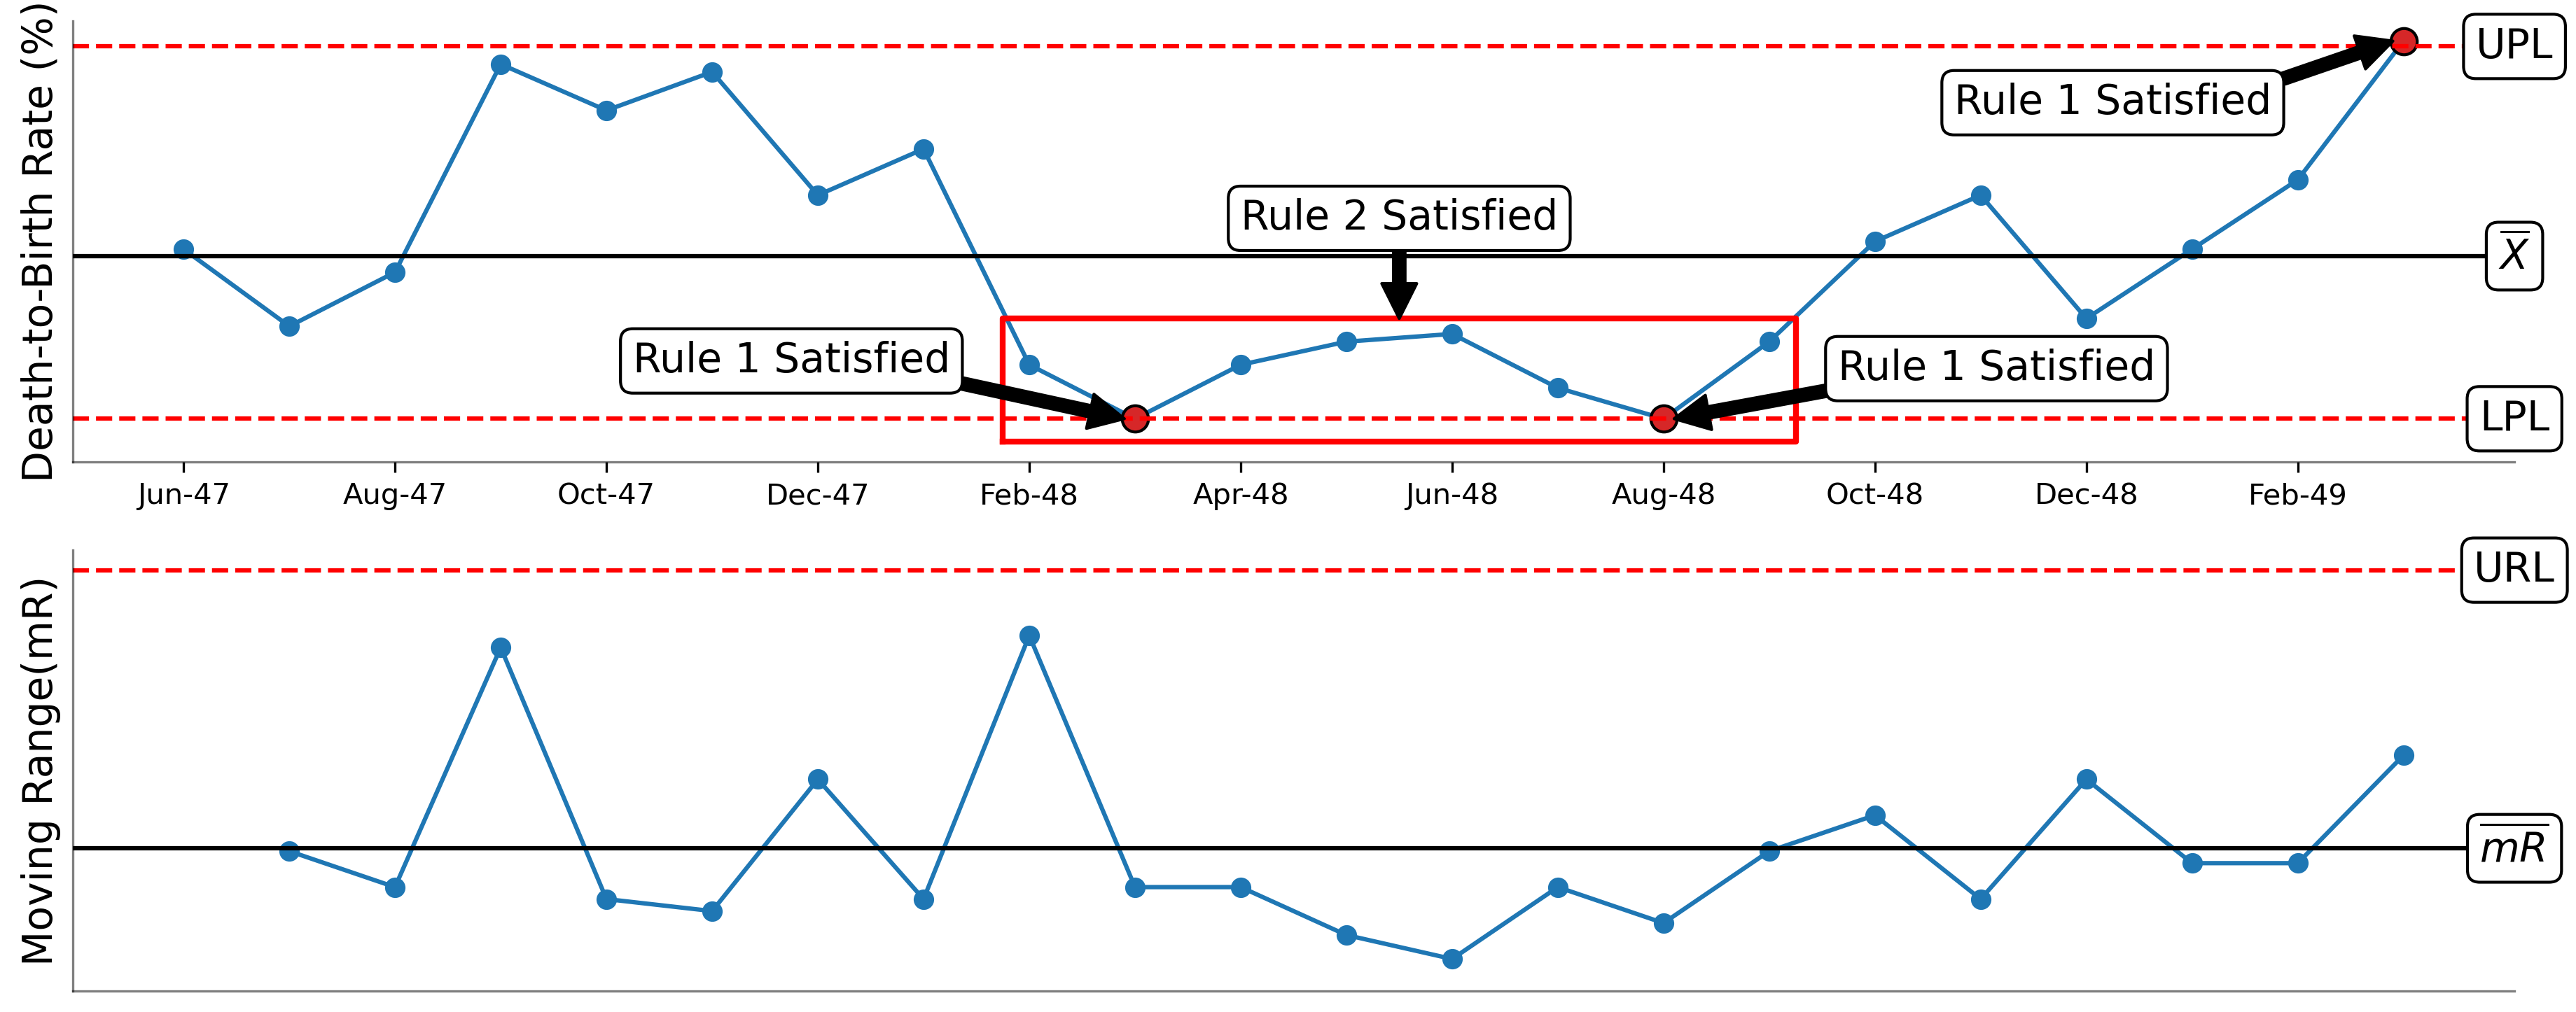

In [11]:
# Specify tickinterval
tickinterval = 2
round_value = 2
# Disaggregate the dataframe 
data = after_df["Rate"]
moving_ranges = after_df['Moving Range']
labels = after_df["MonthYear"]

# labels = pd.Series(np.arange(1,23)).astype('string')

C1 = 2.660
C2 = 3.268

mean = round(data.mean(),2)
average_mR = moving_ranges.mean()

UPL = round(mean + (C1*average_mR),2)
LPL = max(0,mean - (C1*average_mR))
URL = C2*average_mR

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR,'-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Generate the X-chart
fig, ax = plt.subplots(2, 1, figsize=(15,6), dpi=300)

# Plot data 
ax[0].plot(labels, data, marker='o')
ax[1].plot(labels, moving_ranges, marker='o')
    
# Offset moving ranges from individual values by 1.
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add masking parameters to color values outside process limits
ax[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax[0].text(ax[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)

# text labels for limits and central line on mR chart
ax[1].text(ax[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[1].text(ax[1].get_xlim()[1], average_mR, r'$\overline{mR}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)


# Add centerline and process limits 
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, c=color)
    
# Add centerline and process limits for mR chart 
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
ax[0].set_xlabel("",fontsize=12)
ax[0].set_ylabel("Death-to-Birth Rate (%)", fontsize=14)
ax[0].set_yticks([])
ax[0].set_title("", fontsize=14)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_ylabel("Moving Range(mR)", fontsize=14)

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Rule 1 Satisfied', (8.9, 0),(5.75, 0.75)),
    ('Rule 1 Satisfied', (14.1, 0),(17.15, 0.65)),
    ('Rule 2 Satisfied', (11.5, 1.3),(11.5, 2.6)),
    ('Rule 1 Satisfied', (20.9, 4.9),(18.25, 4.1))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    ax[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black')) 

# Add box for highlighting range of values satisfying Rule 3
start_index = 7.75 
end_index = 15.25   
y_min = -0.3  
y_max = 1.3  

# Add a border using plt.plot()
ax[0].plot([start_index, end_index, end_index, start_index, start_index], 
         [y_min, y_min, y_max, y_max, y_min], color='red', linewidth=2)
    
# Despine 
sns.despine()
for axes in range(0,2):
    ax[axes].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Figure 15.3: Rule 3 satisfied with 3 of 4 values closer to the LPL

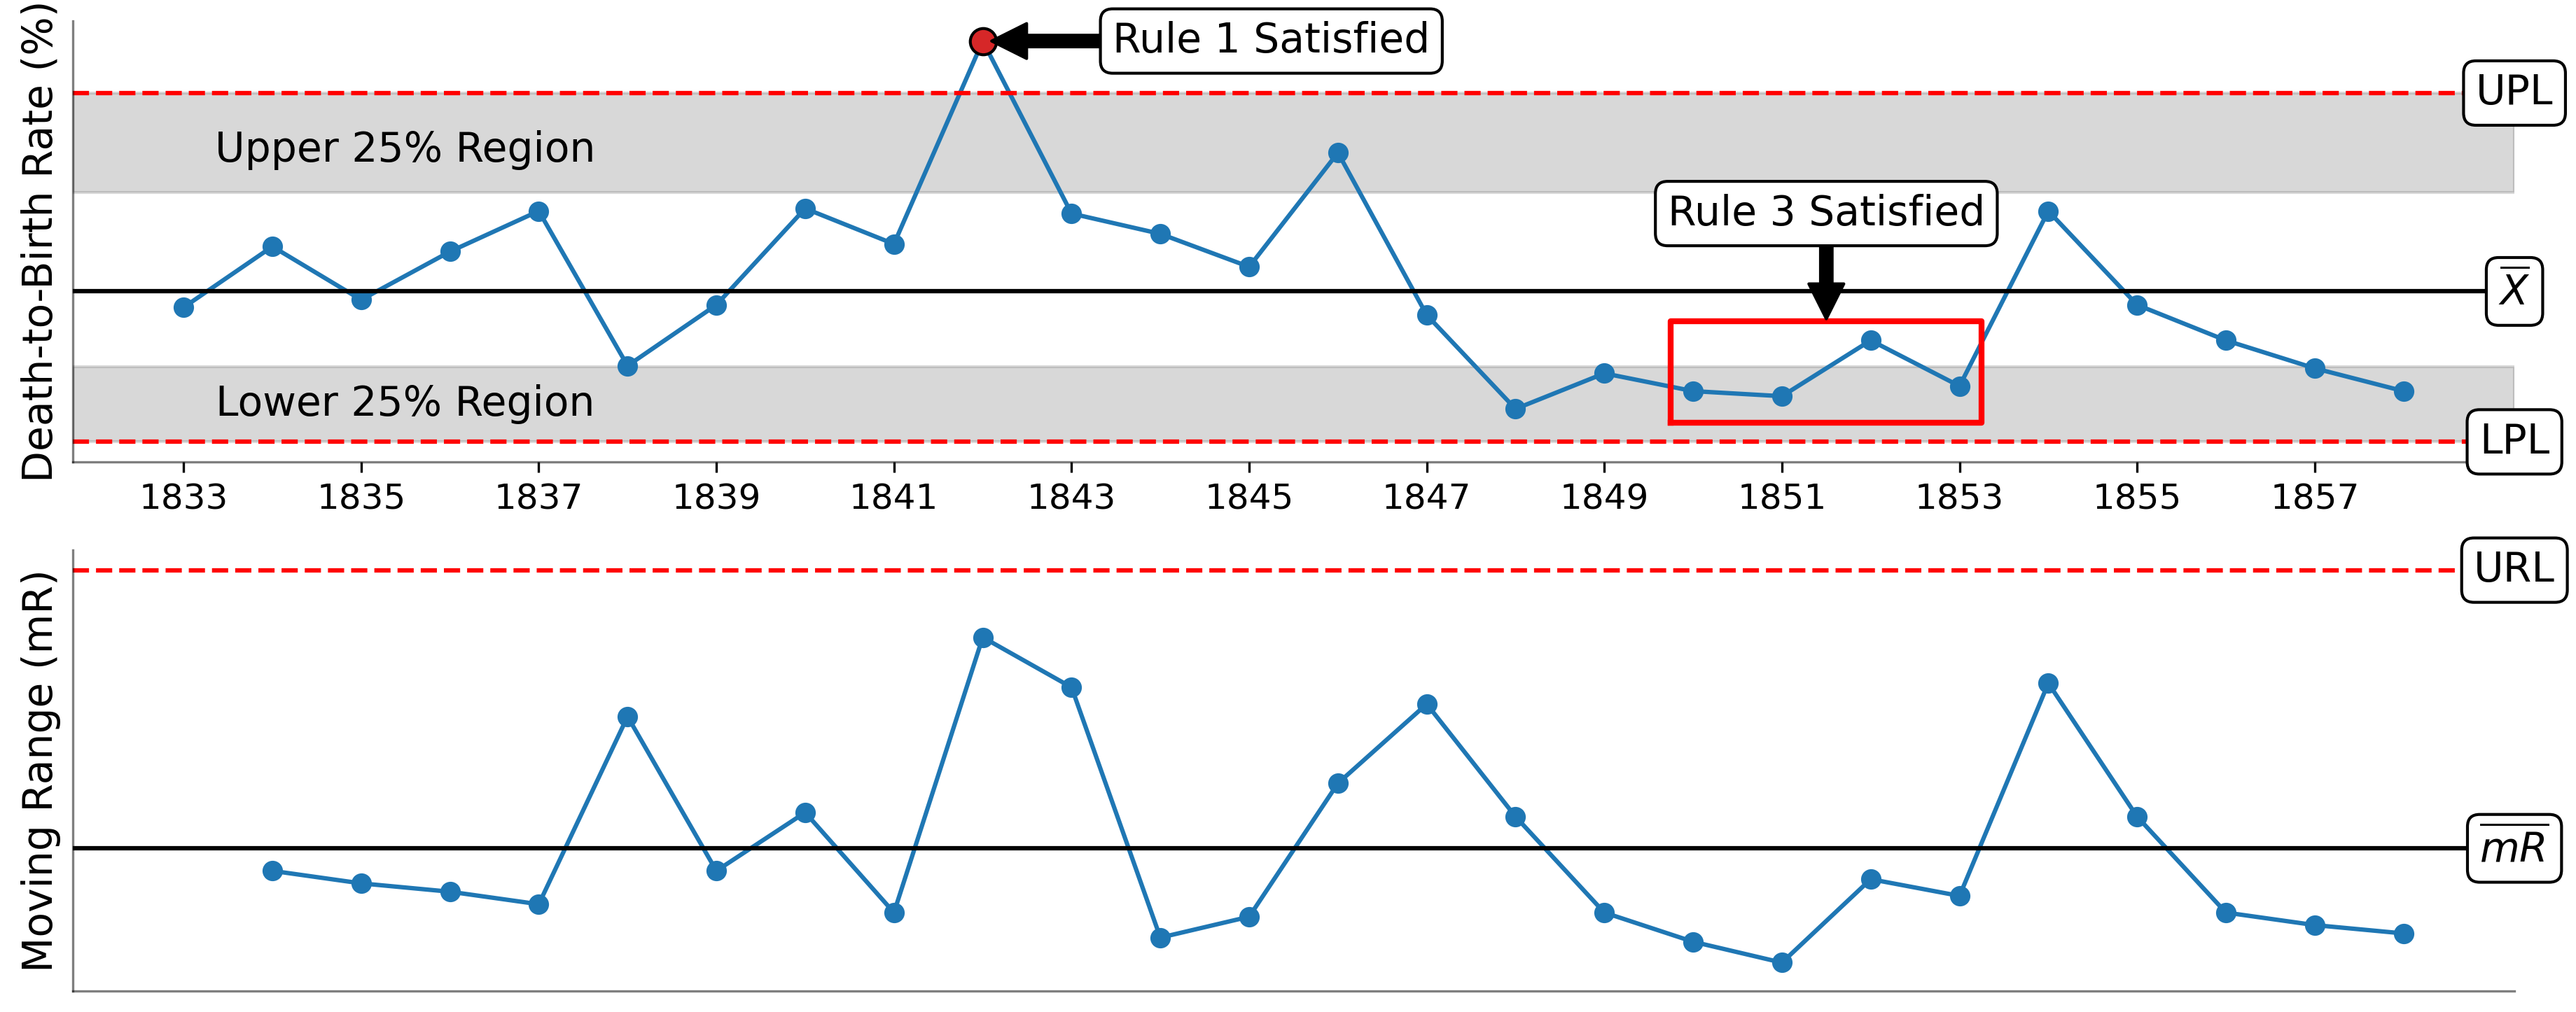

In [12]:
# Specify round_value
round_value = 2

# Specify tickinterval
tickinterval = 2

# Disaggregate the dataframe 
data = first_clinic["Rate"]
moving_ranges = round(abs(data.diff()),round_value)
labels = first_clinic["Year"]
# labels = pd.Series(np.arange(1,27)).astype('string')

# Add moving ranges to df as column
first_clinic = first_clinic.copy()
first_clinic['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = round(mean - (C1*average_mR),round_value)
# Calculate process limit range (PLR)
PLR = UPL - LPL
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)
# Calculate the Upper Range Limit
URL = round(C2*average_mR,round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR,'-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Generate the X-chart
fig, ax = plt.subplots(2, 1, figsize=(15,6), dpi=300)

# Plot data 
ax[0].plot(labels, data, marker='o')
ax[1].plot(labels, moving_ranges, marker='o')
    
# Offset moving ranges from individual values by 1.
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add masking parameters to color values outside process limits
ax[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax[0].text(ax[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[0].text(ax[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)

# text labels for limits and central line on mR chart
ax[1].text(ax[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)
ax[1].text(ax[1].get_xlim()[1], average_mR, r'$\overline{mR}$', color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props)

# Add central line and process limits to X chart
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, c=color)
# Add central line and process limits to mR chart
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, color=color)

# Specify spine visibility 
sns.despine()

# Remove y-ticks
for i in range(0,2):
    ax[i].set_yticks([])

for axes in range(0,2):
    ax[axes].spines[['left','bottom']].set_alpha(0.5)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)
# Remove xticks from mR chart
ax[1].set_xticks([])

# Specify axis labels and title
ax[0].set_xlabel("",fontsize=12)
ax[0].set_ylabel("Death-to-Birth Rate (%)", fontsize=14)
ax[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Add annotation for highlighting value that satisfies Rule 1
ax[0].annotate('Rule 1 Satisfied', 
             xy=(9.1, 15.8),  # x, y coordinates of the annotation
             xytext=(12.25, 15.8),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), 
             arrowprops=dict(facecolor='black'))


# Add box for highlighting range of values satisfying Rule 3
start_index = 16.75 
end_index = 20.25   
y_min = 0.75  
y_max = 4.75  

# Add a border using plt.plot()
ax[0].plot([start_index, end_index, end_index, start_index, start_index], 
         [y_min, y_min, y_max, y_max, y_min], color='red', linewidth=2)

# Adding annotations
ax[0].annotate('Rule 3 Satisfied', 
             xy=(18.5, 4.85),  # x, y coordinates of the annotation
             xytext=(18.5, 9),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center', 
             va='center', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), 
             arrowprops=dict(facecolor='black'))

# Shade region between y=0 and y=2.96
ax[0].axhspan(0, 2.96, color="gray", alpha=0.3)

ax[0].annotate('Lower 25% Region',
            xy=(2.5,1.48),
            fontsize=14,
            color='black',
            ha='center',
            va='center'
            )

# Shade region between y=9.84 and y=13.75
ax[0].axhspan(9.84, 13.75, color="gray", alpha=0.3)

ax[0].annotate('Upper 25% Region',
            xy=(2.5,11.5),
            fontsize=14,
            color='black',
            ha='center',
            va='center'
            )

# Show plot
plt.show()

## Figure 15.4: The detection rule continuum

In [13]:
# Create continuum dataframe
continuum_df = pd.DataFrame()
continuum_df['Y'] = pd.Series([0.5, 0.5, 0.5])
continuum_df['X'] = pd.Series([0.3, 0.5, 0.7])

# Show dataframe
continuum_df

,Y,X
0,0.5,0.3
1,0.5,0.5
2,0.5,0.7


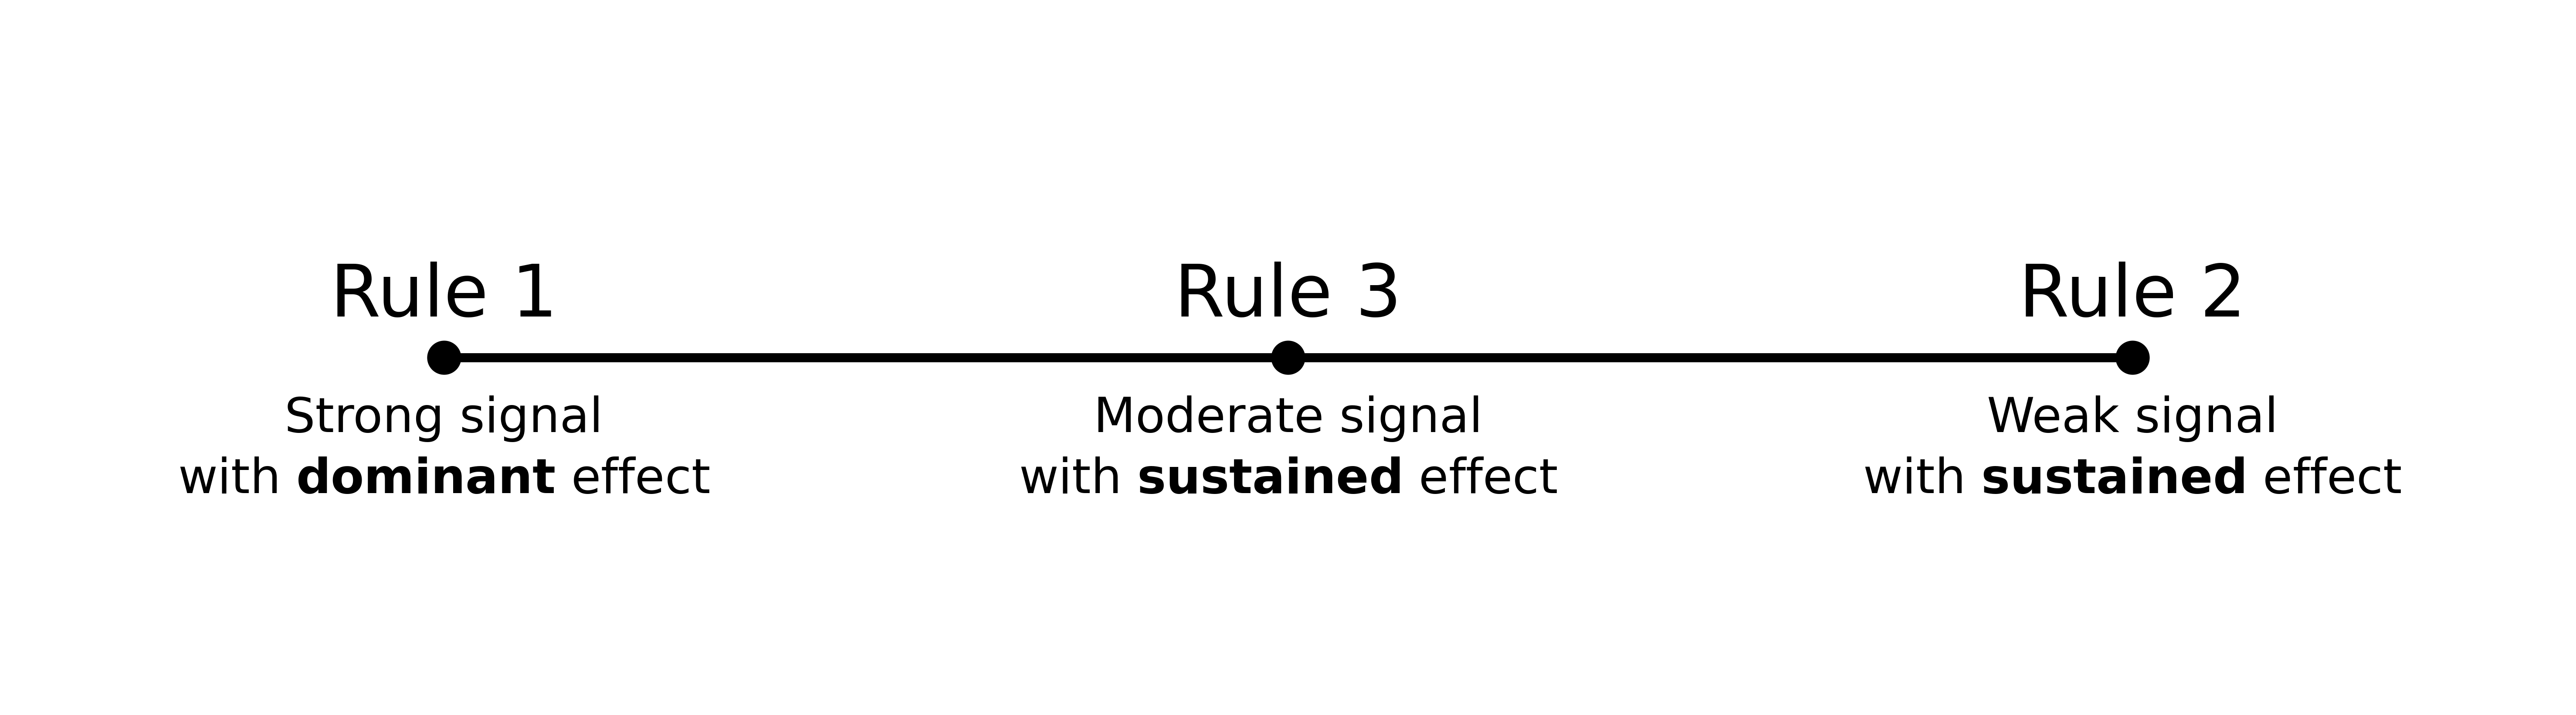

In [19]:
# Suprress seaborn warning for clean display
warnings.filterwarnings(
    "ignore",
    message="use_inf_as_na option is deprecated",
    category=FutureWarning
)

# Create figure
fig, axes = plt.subplots(figsize=(15,4), dpi=500)

sns.scatterplot(x=continuum_df['X'],
                y=continuum_df['Y'], 
                c='black',
                s=150)

sns.lineplot(x=[0.3,0.7], y=[0.5,0.5], c='black', lw=3)

# Define annotations (text, xy-coordinates)
rule_annotations = [
    ('Rule 1', (0.3, 0.505)),
    ('Rule 3', (0.5, 0.505)),
    ('Rule 2', (0.7, 0.505))]

description_annotations = [
    ('Strong signal', (0.3, 0.495)),
    (r'with $\bf{dominant}$ effect', (0.3, 0.490)),
    ('Moderate signal', (0.5, 0.495)),
    (r'with $\bf{sustained}$ effect', (0.5, 0.490)),
    ('Weak signal', (0.7, 0.495)),
    (r'with $\bf{sustained}$ effect', (0.7, 0.490))]

# Add annotations using a loop
for text, xy in rule_annotations:
    axes.annotate(text, xy=xy,
                ha='center', va='center', fontsize=24)
    
# Add annotations using a loop
for text, xy in description_annotations:
    axes.annotate(text, xy=xy,
                ha='center', va='center', fontsize=16)

# Specify x-axis min and max
x_min = 0.20
x_max = 0.80

# Limit x-axis to min and max
axes.set_xlim(x_min, x_max)

# Remove x-axis tick labels and ticks
axes.set_xticks([])
axes.set_yticks([])

# Remove x-axis and y-axis labels
axes.set_xlabel('')
axes.set_ylabel('')

# Despine
sns.despine(left=True, bottom=True)

# Show continuum


plt.show()